In [61]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
from sklearn.linear_model import LinearRegression;
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

### Import data

In [62]:
data = pd.read_csv('Fall18Applicants.csv')

In [63]:
data.head()

AcademicQtrKeyId  ApplQtr  ApplYr  FiscalYr  SDBSrcSystemKey  \
0             20184        4    2018      2019          1986245   
1             20184        4    2018      2019          1986271   
2             20184        4    2018      2019          1986291   
3             20184        4    2018      2019          1986334   
4             20184        4    2018      2019          1986391   

   HolisticAcademicScore  HolisticPQAScore  HolisticAdmissionScore  \
0                     12                 8                      12   
1                     12                 8                      12   
2                     14                 8                      14   
3                     16                 8                      16   
4                     12                 8                      12   

   Parent1_Ed_Level  Parent2_Ed_Level       ...        Other_Budget  Tuition  \
0               5.0               6.0       ...               16431    36578   
1               6.0               5.0       ...               16431    36578   
2               6.0               5.0       ...               16431    36578   
3               6.0               6.0       ...               16431    36578   
4               5.0               6.0       ...               16431    36578   

      FINGroupings  HS_For_Lang_Yrs  HS_Math_Level  HS_Yrs_Arts  \
0  FIN1 - No FAFSA                3              5            0   
1  FIN1 - No FAFSA                3              4            0   
2  FIN1 - No FAFSA                4              5            0   
3  FIN1 - No FAFSA                3              5            0   
4  FIN1 - No FAFSA                3              3            0   

   HS_Yrs_For_Lang HS_Yrs_Math  HS_Yrs_Science  HS_Yrs_Soc_Sci  
0                0           0               0               0  
1                0           0               0               0  
2                0           0               0               0  
3                0           0               0               0  
4                0           0               0               0  

[5 rows x 69 columns]

### Sanity checks

In [64]:
len(data)

22408

In [65]:
data.ApplYr.value_counts()

2018    22408
Name: ApplYr, dtype: int64

In [66]:
data.columns

Index([u'AcademicQtrKeyId', u'ApplQtr', u'ApplYr', u'FiscalYr',
       u'SDBSrcSystemKey', u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'Parent1_Ed_Level', u'Parent2_Ed_Level',
       u'HighestParentalEducation', u'TestScore', u'AcademicScore',
       u'AcademicRank', u'HS_AI', u'HS_GPA', u'HighSchoolCode', u'HS_State',
       u'AgeDecimal', u'AgeYrs', u'FirstGeneration_4YrDegree',
       u'FirstGeneration_Matriculated', u'Athlete', u'CollegeInTheHighSchool',
       u'RunningStart', u'TR_GPA', u'EntryClass', u'AlumOffspring',
       u'Conditional', u'Provisional', u'Major_Req1', u'Old_Major_Category',
       u'CIP', u'NaturalResources', u'Architecture', u'EthnicCultStudies',
       u'Communications', u'Education', u'EngineeringCompSci', u'ForeignLang',
       u'SocialSciences', u'Biology', u'Math', u'HistPhil', u'Psych', u'Arts',
       u'Health', u'Business', u'Dependency', u'FAFSAFiledOnTime', u'EFC',
       u'Income', u'GrantSchol', u'NonPLUSLoan

### Drop unnecessary columns

In [67]:
drop_eps = True

toDrop = ['AcademicQtrKeyId', u'ApplQtr', u'FiscalYr', u'SDBSrcSystemKey', u'StudentName',
          u'FAFSAStudentBudget', u'FAFSATuition', u'TuitionRemainingNoNeg', u'TuitionRemaining', 
          u'TotalBudgetRemainingNoNeg', u'TotalBudgetRemaining', u'Major_Assign1', u'Equity', 
          u'ParentalMaritalStatus', u'appl_rcvd_dt', u'UnfundedNeedNoNeg', u'UnfundedNeed',  
          u'WorkAndAllLoans', u'Total_Budget']
#Other_Budget, 'NonPLUSLoans', u'WorkStudy', u'PLUSLoans', u'WorkAndLoansNoPLUS', 'WorkAndAllLoans'
dataClean = data.drop(toDrop, axis = 1, errors = 'ignore')

### Fill in or drop missing EPS values

In [68]:
epsColumns = ['UWAttraction_TotalCount',
 'UWAttraction_TotalPct',
 'UWAttraction_ProdPct',
 'UWLocationAttraction_TotalCount',
 'UWLocationAttraction_TotalPct',
 'UWEdGoals_TotalCount',
 'UWEdGoals_TotalPct',
 'UWEdGoals_ProdPct',
 'LowerIncomePct',
 'LowerIncomeCount',
 'HigherIncomeCount',
 'LowerParentEdPct',
 'LowerParentEdCount',
 'HigherParentEdCount',
 'CollegeLocationPct_BorderState',
 'FamilyIncomePct_140to200k',
 'FirstGenerationPct_Not1stGen',
 'ParentEducationPct_NoResponse']
epsDerived = ['DeltaParentEdMinusAcademic', 'DeltaAcademicMinusParentEd', 'DeltaIncomeMinusAcademic', 'DeltaAcademicMinusIncome']

In [69]:
if drop_eps:
    dataClean = dataClean.drop(epsColumns + epsDerived, axis = 1, errors = 'ignore')
else:
    for each in epsColumns:
        dataClean.loc[dataClean[each].isnull(), each] = dataClean[each].median()
    # Recalculate values after filling missing in
    dataClean.DeltaParentEdMinusAcademic = (dataClean.LowerParentEdPct / dataClean.LowerParentEdPct.max()) - dataClean.AcademicScore
    dataClean.DeltaAcademicMinusParentEd = dataClean.AcademicScore - (dataClean.LowerParentEdPct / dataClean.LowerParentEdPct.max())
    dataClean.DeltaIncomeMinusAcademic = (dataClean.LowerIncomePct / dataClean.LowerIncomePct.max()) - dataClean.AcademicScore
    dataClean.DeltaAcademicMinusIncome = dataClean.AcademicScore - (dataClean.LowerIncomePct / dataClean.LowerIncomePct.max())

### Clean up major intent

In [70]:
dataClean = dataClean.drop(['Major_Req1', 'Old_Major_Category', 'CIP'], axis = 1)

### Clean up financial aid groupings

In [71]:
finDict = {'FIN1 - No FAFSA':'NoFafsa_Fin1',
'FIN2 - $0 Unfunded':'Unfunded0K_Fin2',
'FIN3 - $1-15K Unfunded':'Unfunded15K_Fin3',
'FIN4 - $15K-30K Unfunded':'Unfunded30K_Fin4',
'FIN5 - $30K-40K Unfunded':'Unfunded40K_Fin5',
'FIN 6 - $40K+ Unfunded':'Unfunded40Kplus_Fin6'}

In [72]:
dataClean.FINGroupings = dataClean.FINGroupings.map(finDict)

In [73]:
dataClean = dataClean.join(pd.get_dummies(dataClean.FINGroupings))
dataClean = dataClean.drop(['FINGroupings'], axis = 1)

In [74]:
dataClean.columns

Index([u'ApplYr', u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'Parent1_Ed_Level', u'Parent2_Ed_Level',
       u'HighestParentalEducation', u'TestScore', u'AcademicScore',
       u'AcademicRank', u'HS_AI', u'HS_GPA', u'HighSchoolCode', u'HS_State',
       u'AgeDecimal', u'AgeYrs', u'FirstGeneration_4YrDegree',
       u'FirstGeneration_Matriculated', u'Athlete', u'CollegeInTheHighSchool',
       u'RunningStart', u'TR_GPA', u'EntryClass', u'AlumOffspring',
       u'Conditional', u'Provisional', u'NaturalResources', u'Architecture',
       u'EthnicCultStudies', u'Communications', u'Education',
       u'EngineeringCompSci', u'ForeignLang', u'SocialSciences', u'Biology',
       u'Math', u'HistPhil', u'Psych', u'Arts', u'Health', u'Business',
       u'Dependency', u'FAFSAFiledOnTime', u'EFC', u'Income', u'GrantSchol',
       u'NonPLUSLoans', u'WorkStudy', u'PLUSLoans', u'WorkAndLoansNoPLUS',
       u'Other_Budget', u'Tuition', u'HS_For_Lang_Yrs', u'HS_Mat

### Clean up other variables

#### Dummify top 10 HS codes and drop the rest

In [75]:
hsCodes = dataClean.HighSchoolCode.value_counts().iloc[:10].index.values
for each in hsCodes:
    dataClean['hs_code_' + str(each)] = (dataClean.HighSchoolCode == each).astype(int)

#### Dummify top 10 HS states and drop the rest

In [76]:
hsStates = dataClean.HS_State.value_counts().iloc[:10].index.values
for each in hsStates:
    dataClean['hs_state_' + str(each)] = (dataClean.HS_State == each).astype(int)

In [77]:
dataClean = dataClean.drop(['HighSchoolCode', 'HS_State'], axis = 1)

#### Clean up others

In [78]:
dataClean['over_20'] = dataClean.AgeDecimal >= 20

In [79]:
dataClean.loc[dataClean.EntryClass == 0, 'EntryClass'] = 1
dataClean = dataClean.join(pd.get_dummies(dataClean.EntryClass, prefix = 'entry_class'))
dataClean['not_freshman'] = dataClean.EntryClass > 1
dataClean = dataClean.drop('EntryClass', axis = 1)

In [80]:
dataClean.CollegeInTheHighSchool = dataClean.CollegeInTheHighSchool.str.strip() == 'Y'
dataClean.RunningStart = dataClean.RunningStart.str.strip() == 'Y'

In [81]:
dataClean.Athlete = dataClean.Athlete > 0
dataClean.FirstGeneration_4YrDegree = dataClean.FirstGeneration_4YrDegree.str.strip() == 'Y'
dataClean.FirstGeneration_Matriculated = dataClean.FirstGeneration_Matriculated.str.strip() == 'Y'

In [82]:
dataClean.Conditional = dataClean.Conditional > 0
dataClean.Provisional = dataClean.Provisional > 0

In [83]:
dataClean.Dependency = dataClean.Dependency.str.strip() == 'Independent'
dataClean['FiledFAFSA'] = ~dataClean.FAFSAFiledOnTime.isnull()
dataClean.FAFSAFiledOnTime = dataClean.FAFSAFiledOnTime.str.strip() == 'Y'

In [84]:
#filling these in with median values
dataClean.loc[dataClean.HS_AI.isnull(), 'HS_AI'] = dataClean.HS_AI.median()
dataClean.loc[dataClean.HS_For_Lang_Yrs.isnull(), 'HS_For_Lang_Yrs'] = dataClean.HS_For_Lang_Yrs.median()
dataClean.loc[dataClean.HS_Math_Level.isnull(), 'HS_Math_Level'] = dataClean.HS_Math_Level.median()
dataClean.loc[dataClean.HS_Yrs_Arts.isnull(), 'HS_Yrs_Arts'] = dataClean.HS_Yrs_Arts.median()
dataClean.loc[dataClean.HS_Yrs_For_Lang.isnull(), 'HS_Yrs_For_Lang'] = dataClean.HS_Yrs_For_Lang.median()
dataClean.loc[dataClean.HS_Yrs_Math.isnull(), 'HS_Yrs_Math'] = dataClean.HS_Yrs_Math.median()
dataClean.loc[dataClean.HS_Yrs_Science.isnull(), 'HS_Yrs_Science'] = dataClean.HS_Yrs_Science.median()
dataClean.loc[dataClean.HS_Yrs_Soc_Sci.isnull(), 'HS_Yrs_Soc_Sci'] = dataClean.HS_Yrs_Soc_Sci.median()

In [85]:
dataClean.TR_GPA.fillna(0, inplace = True)
dataClean['TR_GPA_exists'] = dataClean.TR_GPA > 0

In [86]:
dataClean['HS_Math_over_4'] = dataClean.HS_Math_Level > 4
dataClean['HS_Yrs_Math_over_4'] = dataClean.HS_Yrs_Math > 4
dataClean['HS_Yrs_Science_over_4'] = dataClean.HS_Yrs_Science > 4

### Check final null list

In [87]:
dataClean = dataClean[~dataClean.HS_GPA.isnull()]

In [88]:
dataClean.columns[dataClean.isnull().any()]

Index([u'Parent1_Ed_Level', u'Parent2_Ed_Level', u'HighestParentalEducation',
       u'TestScore', u'EFC', u'Income'],
      dtype='object')

In [89]:
dataClean[dataClean.HS_Yrs_For_Lang.isnull()]

Empty DataFrame
Columns: [ApplYr, HolisticAcademicScore, HolisticPQAScore, HolisticAdmissionScore, Parent1_Ed_Level, Parent2_Ed_Level, HighestParentalEducation, TestScore, AcademicScore, AcademicRank, HS_AI, HS_GPA, AgeDecimal, AgeYrs, FirstGeneration_4YrDegree, FirstGeneration_Matriculated, Athlete, CollegeInTheHighSchool, RunningStart, TR_GPA, AlumOffspring, Conditional, Provisional, NaturalResources, Architecture, EthnicCultStudies, Communications, Education, EngineeringCompSci, ForeignLang, SocialSciences, Biology, Math, HistPhil, Psych, Arts, Health, Business, Dependency, FAFSAFiledOnTime, EFC, Income, GrantSchol, NonPLUSLoans, WorkStudy, PLUSLoans, WorkAndLoansNoPLUS, Other_Budget, Tuition, HS_For_Lang_Yrs, HS_Math_Level, HS_Yrs_Arts, HS_Yrs_For_Lang, HS_Yrs_Math, HS_Yrs_Science, HS_Yrs_Soc_Sci, NoFafsa_Fin1, Unfunded0K_Fin2, Unfunded15K_Fin3, Unfunded30K_Fin4, Unfunded40K_Fin5, Unfunded40Kplus_Fin6, hs_code_999999.0, hs_code_53466.0, hs_code_53218.0, hs_code_53463.0, hs_code_50970.0, hs_code_50718.0, hs_code_51895.0, hs_code_52347.0, hs_code_50893.0, hs_code_51283.0, hs_state_CA, hs_state_OR, hs_state_TX, hs_state_IL, hs_state_CO, hs_state_  , hs_state_--, hs_state_HI, hs_state_FL, hs_state_AZ, over_20, entry_class_1, not_freshman, FiledFAFSA, TR_GPA_exists, HS_Math_over_4, HS_Yrs_Math_over_4, HS_Yrs_Science_over_4]
Index: []

[0 rows x 90 columns]

### Check if ranking is possible

In [107]:
dataClean.HolisticAcademicScore.describe()

count    21509.00000
mean        11.82412
std          4.06014
min          0.00000
25%         10.00000
50%         13.00000
75%         14.00000
max         18.00000
Name: HolisticAcademicScore, dtype: float64

In [108]:
dataClean.TestScore.describe()

count    19362.000000
mean      1311.543745
std        158.872661
min        580.000000
25%       1210.000000
50%       1330.000000
75%       1420.000000
max       1600.000000
Name: TestScore, dtype: float64

In [109]:
dataClean.HS_GPA.describe()

count    21509.000000
mean         3.627880
std          0.315791
min          0.010000
25%          3.460000
50%          3.690000
75%          3.870000
max          4.000000
Name: HS_GPA, dtype: float64

### Impute values

Imputation performed using gradient boosting model

In [ ]:
dataClean['parent1_ed_level'] = dataClean['Parent1_Ed_Level']

In [103]:
scores = [u'HolisticAcademicScore', u'HolisticPQAScore', u'HolisticAdmissionScore']
fafsaCols = ['EFC', 'Income']
toPredictCols = ['parent1_ed_level', 'parent2_ed_level', 'HighestParentalEducation', 'TestScore', 'HighSchoolGPA']
toPredictCols2 = ['TestScore', 'HighSchoolGPA']
otherToDrop = ['ApplYr']

In [104]:
model = LinearRegression(normalize = True)
clf = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 1000, verbose = 1)

#### Impute parent ed1

In [105]:
toFit = dataClean[~dataClean.Parent1_Ed_Level.isnull()]
toPredict = dataClean[dataClean.Parent1_Ed_Level.isnull()]

In [106]:
clf.fit(toFit.drop(otherToDrop + scores + fafsaCols + toPredictCols, axis = 1), toFit.Parent1_Ed_Level)

predictedValues = clf.predict(toPredict.drop(otherToDrop + scores + fafsaCols + toPredictCols, axis = 1)).round()

ValueError: labels ['HighSchoolGPA'] not contained in axis

In [43]:
dataClean['parent1_ed_level'] = toFit.parent1_ed_level.append(pd.Series(predictedValues, index = toPredict.index))

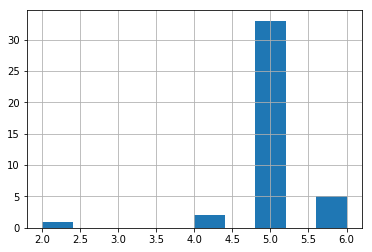

In [44]:
pd.Series(predictedValues, index = toPredict.index).hist()

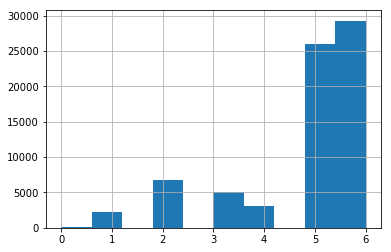

In [45]:
toFit.parent1_ed_level.hist()

#### Impute parent ed2

In [46]:
toFit = dataClean[~dataClean.parent2_ed_level.isnull()]
toPredict = dataClean[dataClean.parent2_ed_level.isnull()]

In [47]:
clf.fit(toFit.drop(otherToDrop + scores + fafsaCols + toPredictCols, axis = 1), toFit.parent2_ed_level)

predictedValues = clf.predict(toPredict.drop(otherToDrop + scores + fafsaCols + toPredictCols, axis = 1)).round()

      Iter       Train Loss   Remaining Time 
         1           2.0543            2.30m
         2           1.8797            2.31m
         3           1.7380            2.31m
         4           1.6231            2.30m
         5           1.5299            2.30m
         6           1.4541            2.30m
         7           1.3926            2.31m
         8           1.3424            2.30m
         9           1.3015            2.32m
        10           1.2680            2.33m
        20           1.1361            2.41m
        30           1.1141            2.37m
        40           1.1063            2.37m
        50           1.1021            2.30m
        60           1.0987            2.24m
        70           1.0964            2.17m
        80           1.0945            2.10m
        90           1.0928            2.04m
       100           1.0908            2.00m
       200           1.0765            1.73m
       300           1.0655            1.51m
       40

In [50]:
dataClean['parent2_ed_level'] = toFit.parent2_ed_level.append(pd.Series(predictedValues, index = toPredict.index))

In [51]:
dataClean['HighestParentalEducation'] = dataClean[['parent1_ed_level', 'parent2_ed_level']].max(axis = 1)

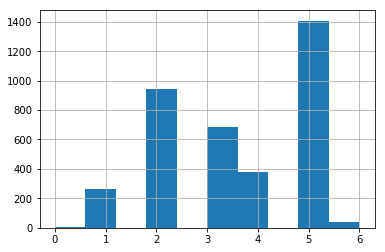

In [52]:
pd.Series(predictedValues, index = toPredict.index).hist()

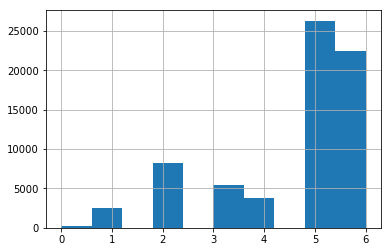

In [53]:
toFit.parent2_ed_level.hist()

#### Impute test scores

In [54]:
toFit = dataClean[~dataClean.TestScore.isnull()]
toPredict = dataClean[dataClean.TestScore.isnull()]

In [55]:
clf.fit(toFit.drop(otherToDrop + scores + fafsaCols + toPredictCols2, axis = 1), toFit.TestScore)

predictedValues = clf.predict(toPredict.drop(otherToDrop + scores+ fafsaCols + toPredictCols2, axis = 1)).round()

      Iter       Train Loss   Remaining Time 
         1       23753.2228            3.18m
         2       21700.9559            3.20m
         3       19998.0526            3.15m
         4       18562.1074            3.10m
         5       17291.1330            3.10m
         6       16272.9353            3.08m
         7       15370.0901            3.05m
         8       14580.4339            3.06m
         9       13935.4818            3.07m
        10       13313.5816            3.07m
        20       10067.1511            3.01m
        30        8812.1248            2.86m
        40        7988.9493            2.70m
        50        7153.5426            2.60m
        60        6191.5131            2.56m
        70        5340.6197            2.52m
        80        4712.6507            2.47m
        90        4232.0159            2.43m
       100        3914.1945            2.39m
       200        2309.1212            2.15m
       300        1676.5581            1.91m
       40

In [63]:
print predictedValues.mean()

1297.48089501


In [64]:
dataClean['TestScore'] = toFit.TestScore.append(pd.Series(predictedValues, index = toPredict.index))
dataClean.loc[dataClean['TestScore'] > 1600, 'TestScore'] = 1600

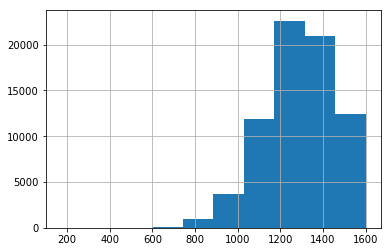

In [65]:
dataClean.TestScore.hist()

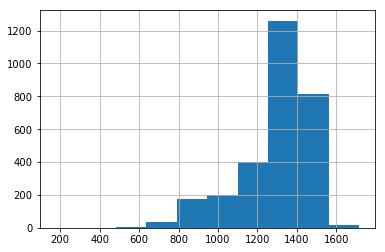

In [60]:
pd.Series(predictedValues, index = toPredict.index).hist()

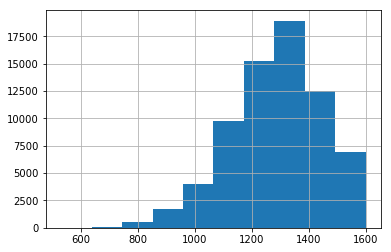

In [57]:
toFit.TestScore.hist()

#### Impute FAFSA cols

In [66]:
dataClean.loc[dataClean.Income < 0, 'Income'] = 0

In [67]:
toFit = dataClean[~dataClean.Income.isnull()]
toPredict = dataClean[dataClean.Income.isnull()]

In [68]:
clf.fit(toFit.drop(otherToDrop + scores + fafsaCols, axis = 1), toFit.Income)

      Iter       Train Loss   Remaining Time 
         1 65360524938.5068            2.01m
         2 62797210874.3107            2.03m
         3 60719540299.3101            2.03m
         4 59026937487.6651            2.03m
         5 57653995659.1829            2.03m
         6 56534114676.7598            2.03m
         7 55624972787.3030            2.03m
         8 54852554718.4067            2.03m
         9 54215774839.9760            2.02m
        10 53720448679.9278            2.02m
        20 51650554041.5744            1.98m
        30 51221706131.0156            1.94m
        40 51047680517.1204            1.91m
        50 50868408253.6733            1.82m
        60 50367255757.8811            1.75m
        70 50115934504.9489            1.69m
        80 49828599033.9543            1.64m
        90 49620084330.3306            1.59m
       100 49447969635.2271            1.55m
       200 47168448677.6201            1.27m
       300 43942841232.1844            1.11m
       40

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)

In [69]:
predictedValues = clf.predict(toPredict.drop(otherToDrop + scores + fafsaCols, axis = 1)).round()
predictedValues[predictedValues < 0] = 0

In [73]:
predictedValues.mean()

21256.966870969034

In [74]:
toFit.Income.describe()

count    4.762600e+04
mean     1.791011e+05
std      2.617501e+05
min      0.000000e+00
25%      5.792700e+04
50%      1.294490e+05
75%      2.254652e+05
max      1.007398e+07
Name: Income, dtype: float64

In [75]:
pd.Series(predictedValues, index = toPredict.index).describe()

count    2.496300e+04
mean     2.125697e+04
std      4.954037e+04
min      0.000000e+00
25%      2.961000e+03
50%      1.506000e+04
75%      2.756600e+04
max      2.342332e+06
dtype: float64

In [76]:
dataClean['Income'] = toFit.Income.append(pd.Series(predictedValues, index = toPredict.index))

In [77]:
toFit = dataClean[~dataClean.EFC.isnull()]
toPredict = dataClean[dataClean.EFC.isnull()]

In [78]:
clf.fit(toFit.drop(otherToDrop + scores + ['EFC'], axis = 1), toFit.EFC)

      Iter       Train Loss   Remaining Time 
         1  7127737695.9191            1.71m
         2  6233360765.6900            1.70m
         3  5501243082.8580            1.71m
         4  4905841024.2950            1.71m
         5  4418414074.0809            1.70m
         6  4021053143.7678            1.70m
         7  3697686375.8002            1.70m
         8  3433898295.0403            1.70m
         9  3217790855.7756            1.70m
        10  3041484662.8079            1.70m
        20  2343392122.4781            1.74m
        30  2221721685.7778            1.68m
        40  2174118229.0633            1.62m
        50  2148383256.0795            1.59m
        60  2133585532.5630            1.54m
        70  2119102235.3208            1.51m
        80  2100178096.3543            1.49m
        90  2090334397.8949            1.46m
       100  2077418510.5209            1.44m
       200  1969068086.9832            1.25m
       300  1855358598.7943            1.07m
       40

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)

In [79]:
predictedValues = clf.predict(toPredict.drop(otherToDrop + scores + ['EFC'], axis = 1)).round()
predictedValues[predictedValues < 0] = 0

In [80]:
predictedValues.mean()

5801.9893442294597

In [81]:
toFit.EFC.describe()

count     47626.000000
mean      53542.521900
std       90722.488968
min           0.000000
25%        5470.000000
50%       26968.000000
75%       64329.500000
max      999999.000000
Name: EFC, dtype: float64

In [82]:
pd.Series(predictedValues, index = toPredict.index).describe()

count     24963.000000
mean       5801.989344
std       17559.002544
min           0.000000
25%        1301.000000
50%        2715.000000
75%        4623.000000
max      774160.000000
dtype: float64

In [83]:
dataClean['EFC'] = toFit.EFC.append(pd.Series(predictedValues, index = toPredict.index))

#### Dummify remaining and recalculate

In [84]:
tempDF = pd.get_dummies(dataClean['HighestParentalEducation'].astype(int), prefix='ed')

tempDF['ed_1m'] = tempDF['ed_1'] + tempDF['ed_2'] + tempDF['ed_3'] + tempDF['ed_4'] + tempDF['ed_5'] + tempDF['ed_6']
tempDF['ed_2m'] = tempDF['ed_2'] + tempDF['ed_3'] + tempDF['ed_4'] + tempDF['ed_5'] + tempDF['ed_6']
tempDF['ed_3m'] = tempDF['ed_3'] + tempDF['ed_4'] + tempDF['ed_5'] + tempDF['ed_6']
tempDF['ed_4m'] = tempDF['ed_4'] + tempDF['ed_5'] + tempDF['ed_6']
tempDF['ed_5m'] = tempDF['ed_5'] + tempDF['ed_6']

dataClean = dataClean.join(tempDF)

In [86]:
dataClean['AcademicScore_imputed'] = (dataClean.HighSchoolGPA / 4.0 * 0.85) + (dataClean.TestScore * 1.0 / 1600.0 * 0.15)

### Final check of nulls

In [87]:
dataClean.columns[dataClean.isnull().any()]

Index([], dtype='object')

### Save outputs

In [88]:
dataClean.to_csv('data_clean_Lavi_V2.csv', index = False)

In [89]:
len(dataClean)

72589

In [90]:
dataClean.columns

Index([u'ApplYr', u'IsEnrolled', u'IsAdmitted', u'PuGoOffer',
       u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation',
       ...
       u'ed_3', u'ed_4', u'ed_5', u'ed_6', u'ed_1m', u'ed_2m', u'ed_3m',
       u'ed_4m', u'ed_5m', u'AcademicScore_imputed'],
      dtype='object', length=108)